**Goals**
1) Mess around with database and understand what data we will work with (nominal/ordinal/quant, which columns can help train a model, which are purely identifiers/not important, use pairplot to look at correlations)
2) Begin to think about training a basic model. Do we want to do separate models for sequence alignment (classification) and quantitative data (regression)? 
3) Think about how we can clean this training data. What features do we want to predict? Aka, which would be most useful when we are missing either the thermophillic or mesophillic sequence from another potential pair?
4) Writing tests for the model will probably be the hardest part. Component 5 doesn't really involve manipulating data in terms of format (this is done in comp. 4). So, we need to think about how to test that the right d-types and columns are being sequestered into ML pipeline. Also need to think about how to run validation tests for inputs and outputs of ML model.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import duckdb

In [2]:
# seaborn plot configurations
sns.set_context('talk')
#sns.set_style('whitegrid')
palette = sns.color_palette('colorblind')

In [3]:
# establishing connection to the database (from local repo)
con = duckdb.connect('/Users/loganroberts/Learn2Therm/ValidProt/data/Sample')

In [4]:
#need to speak with Humood and understand what duckdb connection is doing. I assume its a tool to query database
#humood seems to have chosen particular data to work with. Talk to him ab these choices

con

In [5]:
df = pd.read_csv("/Users/loganroberts/Learn2Therm/ValidProt/data/Sample.csv")

In [47]:
df

,Unnamed: 0,prot_pair_index,meso_seq,thermo_seq,meso_ogt,thermo_ogt,scaled_local_symmetric_percent_id,local_E_value,scaled_local_query_percent_id,local_gap_compressed_percent_id
0,1256842,126227630,MLLSDRDLVSEIKSGDLSLEPFEPALLQPSSIDVRLDRFFRVFNNH...,MLLSDRDLRKELESGRLELDPFDPAMLQPSSIDVRLDRFFRVFDNT...,27.5,45.0,0.777202,0.0,0.773196,0.802139
1,1456567,169784592,MRFEGTSGYVATDDLKVAVNAAIALERPLLVKGEPGTGKTVLAVEV...,MKFTGSDSYVATEDLMIAVNAAVTLERPLLVKGEPGTGKTELARQV...,30.0,54.0,0.782143,0.0,0.784946,0.784946
2,874464,31933768,MAYETINVDVQDHVCLIKLHRPEALNALNAALVSELCTALEEADAS...,MAYKTIIVEIEDHVALIKLNRPEALNALNSELLGELAQAVTEADAN...,19.5,54.0,0.775194,0.0,0.775194,0.775194
3,560201,32409414,MAIRKYKPTTPGRRGSSVADFAEITRSTPEKSLLRPLSKTGGRNNQ...,MGIRKYKPTTPGRRGASVADFVELTRREPEKSLLRPLPKKGGRNNR...,28.0,52.5,0.787770,0.0,0.790614,0.802198
4,33257,175862226,MLQRLQDRVAVVTGGGSGIGLATVRRFAAEGAKVVVADIDAAAGEA...,MSEDIICRRLTGRTAVVTGAGSGIGLASARRLASEGANVVCADVDE...,28.0,45.0,0.788350,0.0,0.780769,0.802372
...,...,...,...,...,...,...,...,...,...,...
9995,458544,42061208,MRFVIARCQVDYVGRLTAHLPMANRLVMVKSDGSVLVHSDGGSYKP...,MRLVIARCQVDYVGRLTAHLPMAQRLLLIKADGSVSVHSDDRAYKP...,28.0,45.0,0.872146,0.0,0.872146,0.872146
9996,469612,165123678,MKPIVGSIVALITPMHEDGSVDYPALRKLIDWHIAEGTDCIGVVGT...,MTSSRVTLTGSIVALVTPMHEDGSVDYPTLRKLIDWHIAQGTDCIS...,30.0,48.0,0.764805,0.0,0.758389,0.776632
9997,226964,71308777,MSFFAPKTVVSAHCDLPCGVYDPAQARIEAESIKAVAEKYQANTDP...,MLSRLFAPTVEVSAHCDLPCGVYDPAQARIEAQSIKAIIEKYHASD...,30.0,52.5,0.777358,0.0,0.768657,0.804688
9998,123183,137720058,MRLVIARCSVDYVGRLTAHLPMATRLLLVKADGSVSVHADDRAYKP...,MRLVIARCQVDYHGRLTAHLPMATRLVLIKADGSVSIHSDDRAYKP...,32.0,50.0,0.737557,0.0,0.744292,0.740909


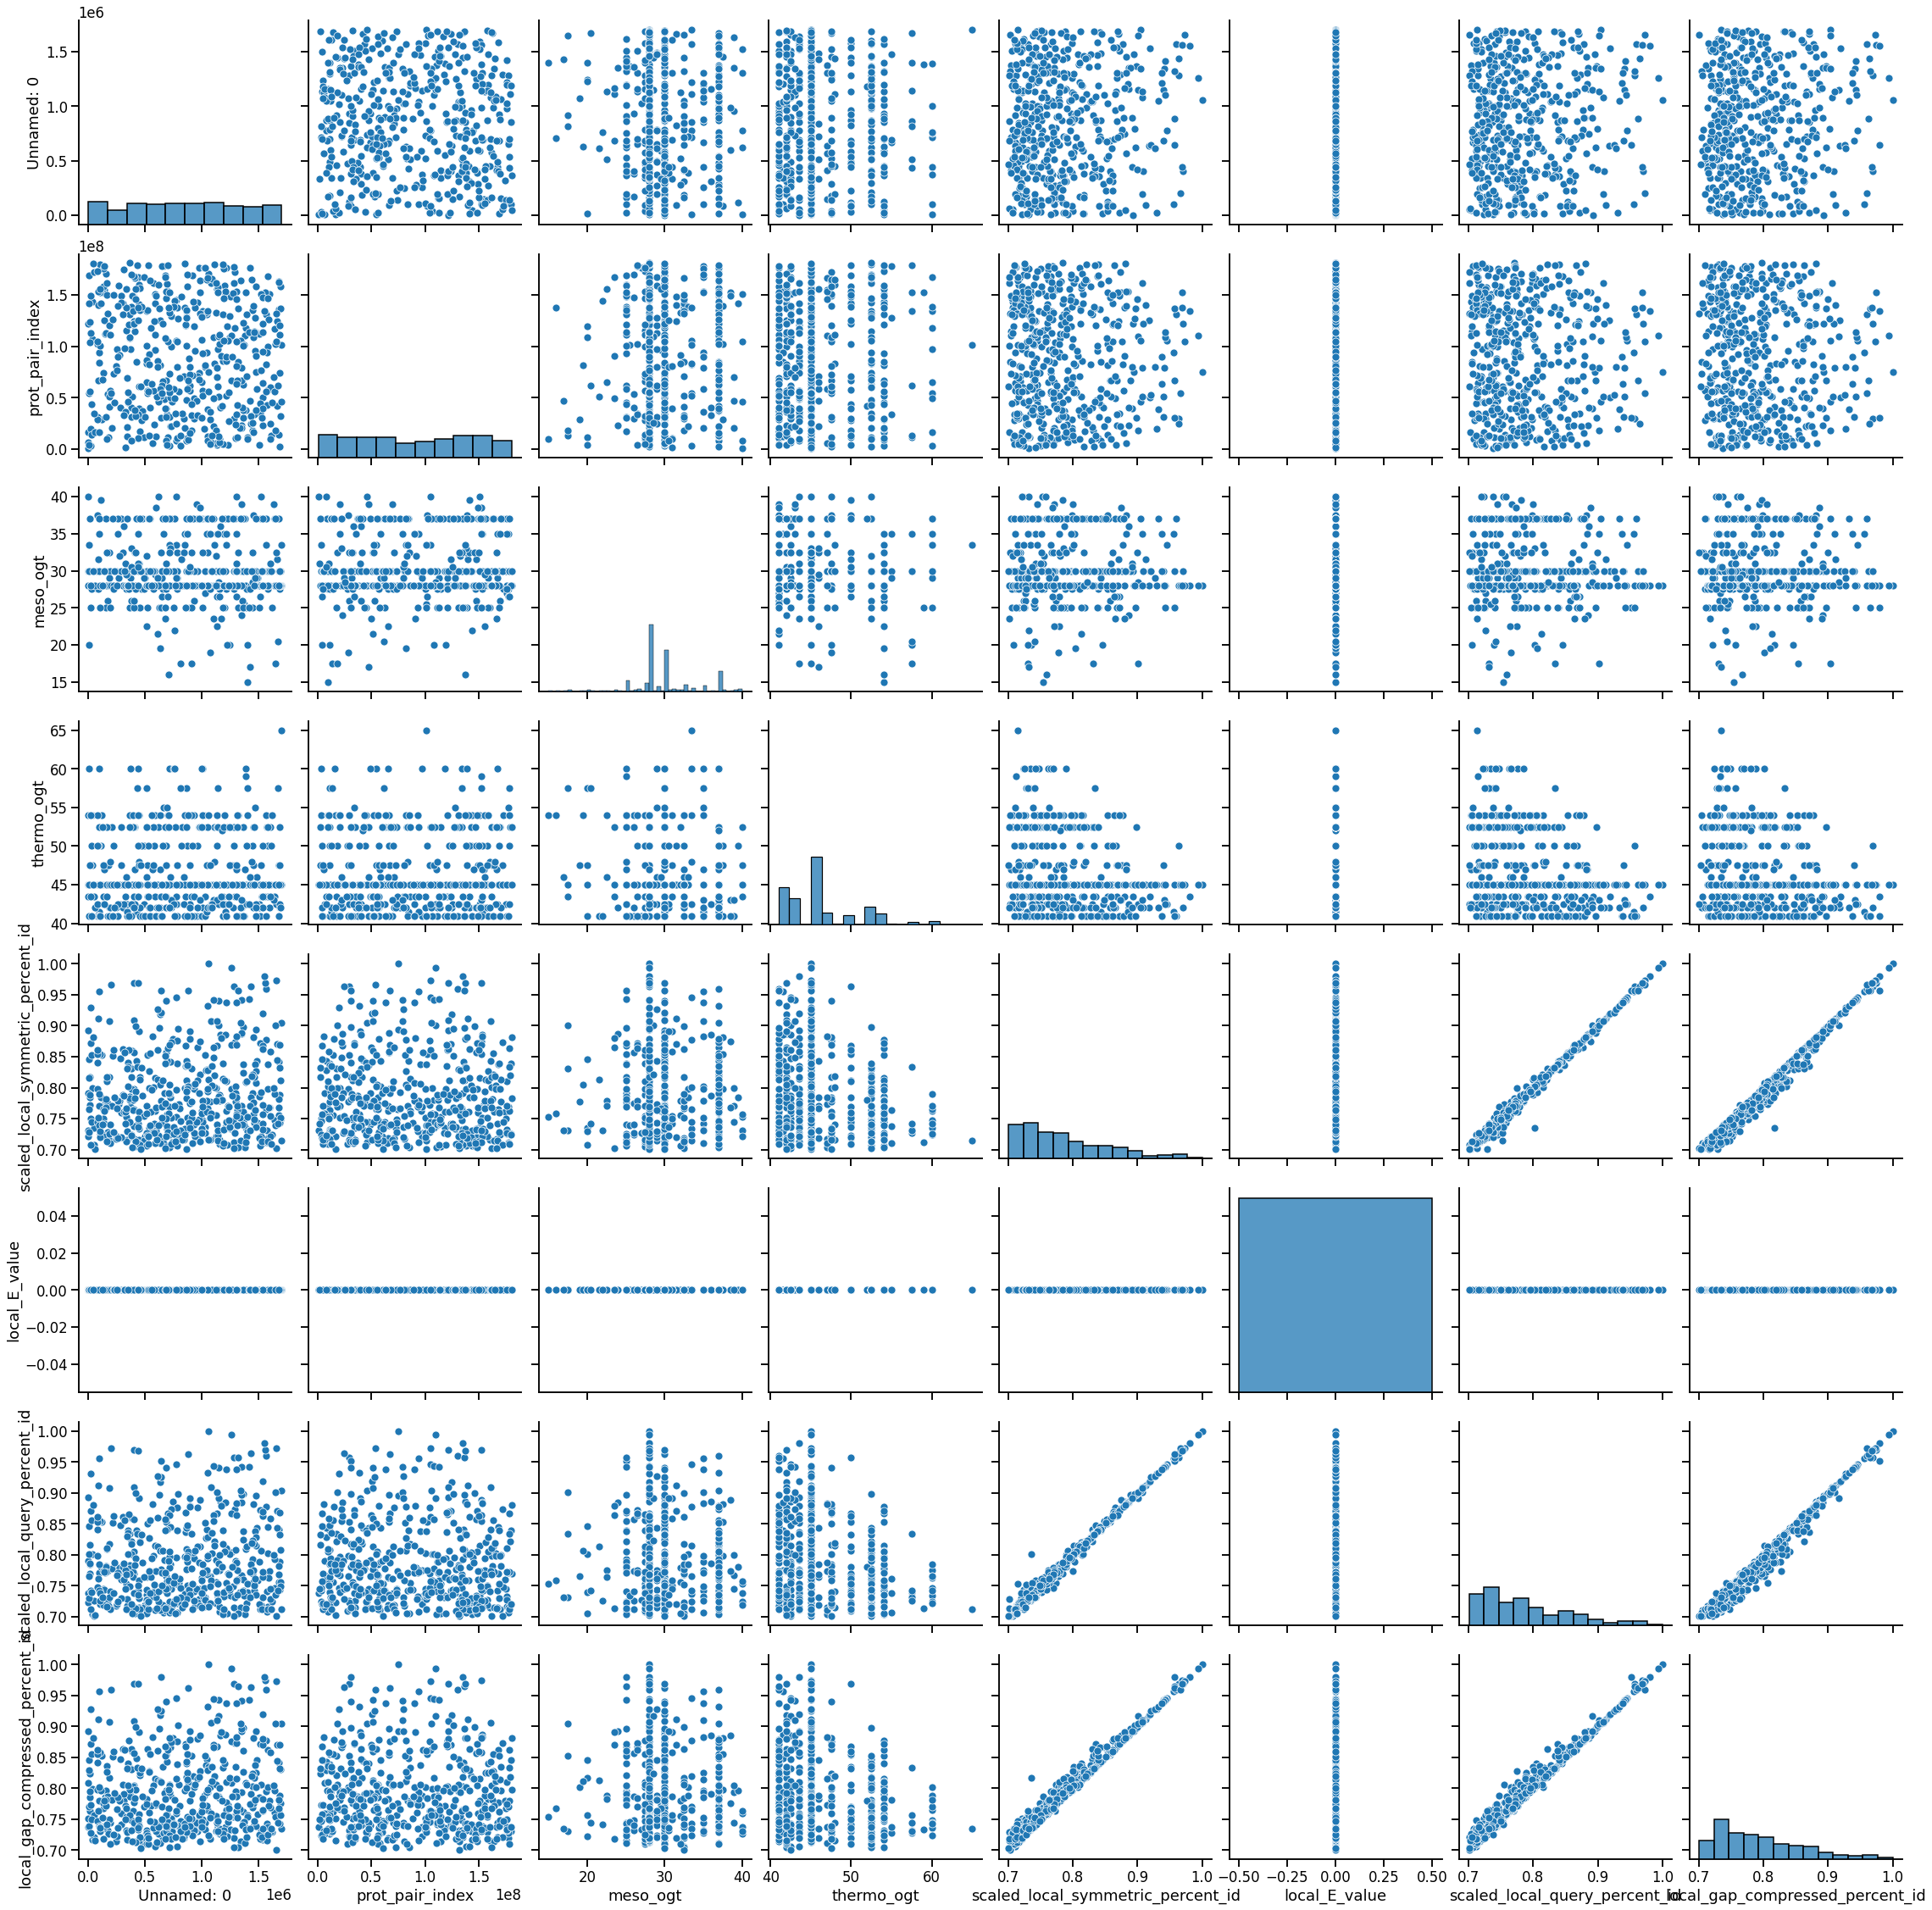

In [7]:
sns.pairplot(df.sample(500),height = 4 )

Candidates for measurable outputs:
scaled symmetric percent id
scaled local query percent id
local gap compressed percent id

In [8]:
# same code as last NB
def seperate_nominal_features(dataframe, target_name, nominal_features=[]):
    """Splits data columns into nominal X, quantitative X, and the target y
    
    Returns
    -------
    dict of (nominal_X, quantitative_X, y)
    """
    # get y values
    y = dataframe[target_name].values.reshape(-1,1)
    
    # get all other columns
    quantitative_features = [c for c in dataframe.columns if c not in nominal_features and c != target_name]
    
    # return the data seperated
    return {
        'nominal_X': dataframe[nominal_features].values,
        'quantitative_X': dataframe[quantitative_features].values,
        'y': y
    }

In [9]:
nominal_features = df[['meso_seq', 'thermo_seq']]
quant_features = df.drop(columns=['meso_seq', 'thermo_seq'])

print(nominal_features.shape)
print(quant_features.shape)

(10000, 2)
(10000, 8)


In [52]:
def calculate_levenshtein_distance(seq1, seq2): 
    """
    Calculates percent similarity (Levenshtein distance, normalized) between two amino acid sequences.
    
    Input: Two amino acid sequences (String, will need to index from dataframe "nominal features")
    Output: Float (percent similarity)
    """
    #import package to calculate levenshtein
    #note-this should be same as local gap compressed ID
    from fuzzywuzzy import fuzz

    string1 = seq1
    string2 = seq2

    levenshtein_distance = fuzz.ratio(string1, string2)/100
    return round(levenshtein_distance, 5)

In [12]:
model_df = df.drop(columns=['Unnamed: 0', 'local_E_value', 'prot_pair_index'])

In [13]:
# potential ML model for nominal features with KNN

dev_data, test_data = sklearn.model_selection.train_test_split(model_df, test_size=0.15, random_state=100) # asking for 15% of the data to be test set

print(str(dev_data.shape) + str(test_data.shape))

(8500, 7)(1500, 7)


In [53]:
#probably need to format this differently

dev_data_nom = dev_data[['meso_seq', 'thermo_seq']]
test_data_nom = test_data[['meso_seq', 'thermo_seq']]

In [54]:
#one hot encode nominal data
# create encoder object
encoder = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
# fit and encode the nominal features
encoded_noms = encoder.fit_transform(dev_data_nom.values.reshape(-1,1))

# transform the data in both datasets
# dev_data = encoder.transform(dev_data_nom)

In [ ]:
#potential ML model for quantitative features with linear regression